# Week 2 The Kaggle Titanic dataset
## streamlining Feature engineering and model comparison for machine learning
### analysis is performed mainly with sci-kit learn included functions.

In [48]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # not used, no Hyperparameter optimization

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # not used, only for possible comparison
from sklearn.ensemble import RandomForestClassifier # not used, only for possible comparison

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

# read and split the data

In [55]:
df = pd.read_csv('train.csv', index_col = 0)

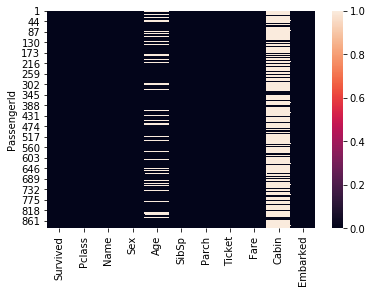

In [3]:
sns.heatmap(df.isna())

In [56]:
y = df['Survived']

In [57]:
X = df.drop(columns= ['Survived'])

In [8]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


### fill missing values
#### manually filling of especially the missing age values based on Sex and Pclass median improves the model only slightly, still it could be done
- for the age column by mean of corresponding Pclass and Sex:
- for the embarked column by the most frequent entry: 'S

In [14]:
X['Embarked'] = X['Embarked'].fillna('S')

In [15]:
repl_age=X.groupby(['Pclass', 'Sex'])['Age'].transform('median') # fill missing age values 
X['Age']= X['Age'].fillna(repl_age)
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [59]:
X_test['Age'].isna().sum(), X_train['Age'].isna().sum()

(45, 132)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((668, 10), (668,), (223, 10), (223,))

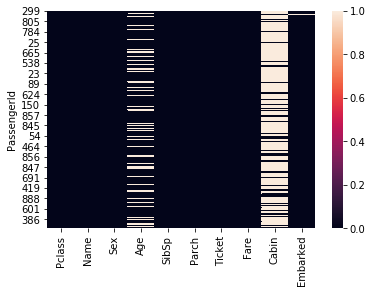

In [60]:
sns.heatmap(X_train.isna())

# Feature engineering start

In [61]:
# to extract the title from the name column, the following function is used, taken and adapted from https://github.com/zlatankr/Projects/blob/master/Titanic/Titanic%20Model%20Walk-Through.ipynb
def name_from_title(df):
    for i in [df]:
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return df

In [62]:
# Feature engineering using above defined helper function
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('my_bins', KBinsDiscretizer(n_bins = 4, encode = 'onehot', strategy = 'quantile'))
    ])
#('scaler', StandardScaler())

categorical_features = ['Embarked' , 'Sex', 'Pclass', 'SibSp', 'Parch']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

name_feat = ['Name']
name_transformer = Pipeline(steps=[
    ('title_extract', FunctionTransformer(name_from_title)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('title_extract', name_transformer, name_feat)])

### fit the model & model metrices

In [66]:
# Append classifier to preprocessing pipeline.
p = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

In [70]:
# fit the model, call accuracy score
p.fit(X_train, y_train)
p.score(X_train, y_train)

0.8413173652694611

In [71]:
p.score(X_test, y_test)

0.8071748878923767

## perform testing and validation options
### cross validation with sklearn function
### bootstrapping with python script from SPICED

In [72]:
cross_val_score(p, X_train, y_train, cv = 5, scoring = 'accuracy')

array([0.79104478, 0.86567164, 0.79104478, 0.79699248, 0.84962406])

In [73]:
# bootstrapping with python program from SPICED:
boots = []
for i in range(1000):
    Xb, yb = resample(X_train, y_train)
    p.fit(Xb, yb)
    score = p.score(Xb, yb)
    boots.append(score)
    print(i, score)

0 0.8038922155688623
1 0.8323353293413174
2 0.8353293413173652
3 0.8263473053892215
4 0.8502994011976048
5 0.8637724550898204
6 0.8398203592814372
7 0.8188622754491018
8 0.844311377245509
9 0.8488023952095808
10 0.8413173652694611
11 0.8413173652694611
12 0.8592814371257484
13 0.8293413173652695
14 0.8353293413173652
15 0.8248502994011976
16 0.8338323353293413
17 0.8502994011976048
18 0.8308383233532934
19 0.8338323353293413
20 0.8473053892215568
21 0.8502994011976048
22 0.8278443113772455
23 0.8293413173652695
24 0.8607784431137725
25 0.8308383233532934
26 0.8338323353293413
27 0.844311377245509
28 0.8622754491017964
29 0.8473053892215568
30 0.8308383233532934
31 0.8338323353293413
32 0.8488023952095808
33 0.8607784431137725
34 0.812874251497006
35 0.8458083832335329
36 0.8532934131736527
37 0.8473053892215568
38 0.8502994011976048
39 0.8577844311377245
40 0.8607784431137725
41 0.8278443113772455
42 0.8188622754491018
43 0.8323353293413174
44 0.8353293413173652
45 0.8068862275449101
4

365 0.8368263473053892
366 0.8353293413173652
367 0.8532934131736527
368 0.8323353293413174
369 0.8323353293413174
370 0.8622754491017964
371 0.8577844311377245
372 0.8263473053892215
373 0.8682634730538922
374 0.8607784431137725
375 0.8488023952095808
376 0.8622754491017964
377 0.874251497005988
378 0.8323353293413174
379 0.8727544910179641
380 0.8398203592814372
381 0.8502994011976048
382 0.842814371257485
383 0.8263473053892215
384 0.8592814371257484
385 0.8173652694610778
386 0.8502994011976048
387 0.8368263473053892
388 0.8577844311377245
389 0.8532934131736527
390 0.844311377245509
391 0.8458083832335329
392 0.8607784431137725
393 0.8413173652694611
394 0.8577844311377245
395 0.844311377245509
396 0.8398203592814372
397 0.8353293413173652
398 0.8413173652694611
399 0.8278443113772455
400 0.8203592814371258
401 0.8562874251497006
402 0.8517964071856288
403 0.8787425149700598
404 0.8652694610778443
405 0.874251497005988
406 0.8562874251497006
407 0.8308383233532934
408 0.8607784431

724 0.8458083832335329
725 0.8637724550898204
726 0.8353293413173652
727 0.8562874251497006
728 0.842814371257485
729 0.8188622754491018
730 0.8562874251497006
731 0.8607784431137725
732 0.8532934131736527
733 0.8248502994011976
734 0.8667664670658682
735 0.8458083832335329
736 0.8727544910179641
737 0.8413173652694611
738 0.8383233532934131
739 0.8248502994011976
740 0.875748502994012
741 0.8323353293413174
742 0.8398203592814372
743 0.8368263473053892
744 0.842814371257485
745 0.8398203592814372
746 0.842814371257485
747 0.8652694610778443
748 0.8248502994011976
749 0.8458083832335329
750 0.8667664670658682
751 0.8083832335329342
752 0.8502994011976048
753 0.8532934131736527
754 0.8338323353293413
755 0.8338323353293413
756 0.8577844311377245
757 0.8413173652694611
758 0.8458083832335329
759 0.8502994011976048
760 0.8293413173652695
761 0.8293413173652695
762 0.8682634730538922
763 0.8308383233532934
764 0.8368263473053892
765 0.8547904191616766
766 0.8532934131736527
767 0.859281437

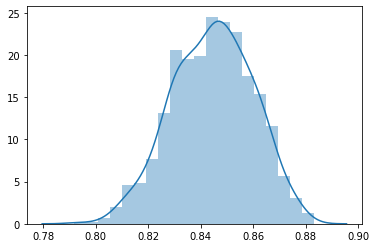

In [74]:
# plot the score distribution
sns.distplot(boots, bins = 20)

In [45]:
# get percentiles for 95% confidence
ci95 = boots[25:-25]
print(f"95% confidence interval: {ci95[0]:5.2} -{ci95[-1]:5.2}")

95% confidence interval:  0.84 - 0.83


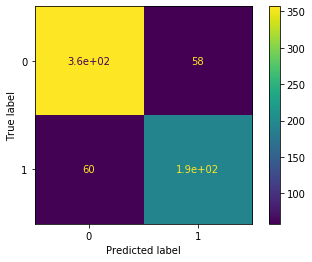

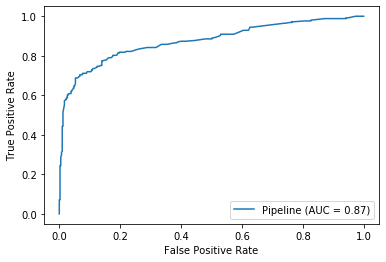

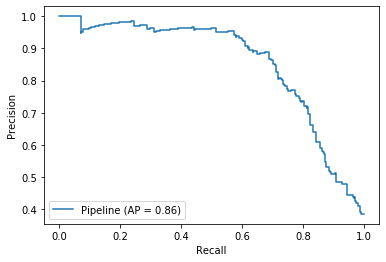

In [46]:
plot_confusion_matrix(p, X_train, y_train)
plot_roc_curve(p, X_train, y_train)
plot_precision_recall_curve(p, X_train, y_train)

Text(0, 0.5, 'True Positive Rate')

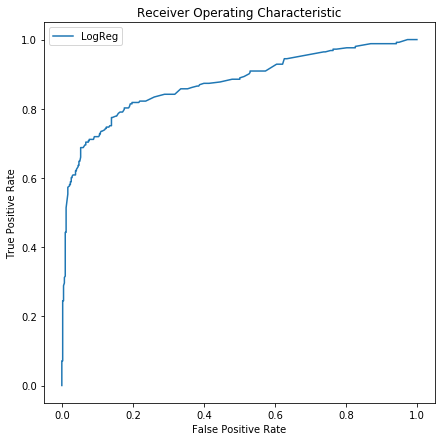

In [49]:
# to plot ROC for several models us following code
models = [p] # list of different models to be plotted
labels = ['LogReg'] # list of labels for the different
plt.figure(figsize=(7,7))
for i in models:
    y_pred_prob = i.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds= roc_curve(y_train, y_pred_prob)
    plt.plot(fpr, tpr)
plt.legend(labels)
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [ ]:
# similarily for precision-recall curve
models = [p]# list of different models to be plotted
labels = ['LogReg' ]# list of labels for the different
plt.figure(figsize=(7,7))
for i in models:
    y_pred_prob = i.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds= precision_recall_curve(y_train, y_pred_prob)
    plt.plot(fpr, tpr)
plt.legend(labels)
plt.xlabel("Recall: TP/(TP + FP)")
plt.ylabel("Precision: TP/(TP + FN)")
plt.title('Precision Recall Curve')

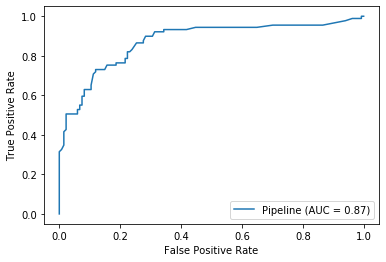

In [75]:
# for the actual splitted test data
plot_roc_curve(p, X_test, y_test)